<p align="center">
<h1>Visual Communication (ViCOM) tutorial with exercises: Kinematic analysis of head and body (face and acoustics)</h1>
  <h2>Research Colloquium “Visual Communication (ViCom)”</h2>
  <img src="./images/vicom_logo.png" alt="Vicom" width="300"/>
  <img src="./images/envision_banner.png" alt="envisionBOX" width="300"/>
  <h4>Author notebook: Wim Pouw (wim.pouw@donders.ru.nl), in collaboration with Cornelia Ebert and Markus Steinbach</h4>
</p>

# Background current module
This tutorial was made in the context of a seminar about visual communication in the context of (potentially ambiguous) responses to negated statements ("she did not go to school" -> "yes"). What are the multimodal resources one can recruit to contextualize, transform, or even replace, what you mean in such responses against the lexicalized aspects of speech or sign? How would we analyze the presence and absence, and the degree to which, such multimodal resources are exploited? There are no single answers and solutions to such questions. But here is one particular operationalization of looking at multiple aspects of communicative movement, and extracting features to further work with them in your analysis. Importantly, this tutorial also underlines the necessity of sanity checking, by using dynamic visualizations which I think can be helpful for communicating your science too.

# General workflow
We will start overviewing the example data, which contain short responses to statements, and we overview the extracted motion timeseries. Then we extract head movement features and hand movement features. We follow up with

* Section 0: setting up, and overview motion tracking
* Section 1: kinematics of head movements
* Section 2: kinematics of hand movements
* Section 3: checking your measures with animations
* Section 4: From measures to dataset

Future work (if I or anyone else who would like to contribute finds some time):
* Section 5: eye brow motions (TO DO)
* Section 6: vocal-prosodic analyses (TO DO)
* ...[]...

# Installation
As always, please install the requirements to get all packages needed. Navigate to the folder containing the requirements.txt in your terminal (OS) or conda command prompt (windows) and run
* conda install pip
* pip install -r requirements.txt'

#### Did you find this helpful for your research, please cite:



# Section 1: Setting up, and overview motion tracking
### Identifying the relevant folders
We are first going to identify the relevant folders that we have. We will be working with masked video data that is already processed with mediapipe's holistic tracking module, containing the face kinematics with head rotations, and body and hand kinematic data. Below we identify the relevant folders and also show an example video of the kind of kinematic data we work with,

In [182]:
import os            #folder designating
import pandas as pd  #data wrangling and data framing
from IPython.display import Video # videodisplay and writing
import numpy as np # numerical operations
import glob as glob # file handling
import matplotlib.pyplot as plt # plotting

#Load in the data that specifies each condition and related information to each trial video
meta = pd.read_csv("../meta/meta_dummy.csv")
#initialize the folder where the processed data is saved
processed_data_fol = '../processed_data/'
#raw_video_fol = '../raw_videos/' #we will not be working with raw videos as they contain identifiable information

#initialize the folder where masked video data is saved                                         
masked_video_fol = '../masked_videos/reencoded/'
augemented_video_fol = '../augmented_videos/'
# for automated annotations
automated_annotation_fol = '../meta/automated_annotations/'
# get all videos
all_videos = glob.glob(masked_video_fol + '*.mp4')
# get all raw videos
all_raw_videos = glob.glob(raw_video_fol + '*.mp4')

# show the meta data
print(meta.head())
select_example = meta['trial_name'][6]
select_example2 = meta['trial_name'][5]
print('we are going to work with the following example: ' + select_example)

  trial_name condition  type
0   01_b_P16    dummy1  test
1    02_a_P8    dummy1  test
2    09_a_P7    dummy2  test
3   17_a_P15    dummy2  test
4   21_b_P12    dummy1  test
we are going to work with the following example: 34_a_P12


## Current data
We have 8 masked videos containing responses in German sign language DGS (Loos, Steinbach, Repp, in prep). 

In [170]:
# show a video of the example in a small size
Video(masked_video_fol + select_example + '.mp4', embed=True, width=300)

In [171]:
# show a video of the example, concatenate example 1 and 2 to show the full video
Video(masked_video_fol + select_example2 + '.mp4', embed=True, width=300)

### Some notes on the the current data
This video data has been set up in a way that might not necessarily be ideal for the computer vision methods we use to study movement. Consider a couple of things below in the videos concatenare below and above (for the full videos):

#### In all casese the full body is not visible in the frame
What this means is that the computer vision model will try to infer the bodies locations based on the available information about the body posture in the frame. Importantly, the video-based motion tracking models usually have a likelihood or "visibility" variable that provide you some information about whether the current estimate of some body keypoint is reliable or not. Since we are working with opportunistic rather than designed data here, we will therefore code into our calculations of the features that we want to base our measures on visible movements. However, if you design your experiment, a good rule of thumb is to have the whole body visible at all times during your recordings.

#### Movement versus communicative movements
In the current data the participants also have to interact with the computer to go to the next trial. However, this requires the body to organize into a keypressing device, which means you get head movements that guide gaze and you will have hand movements. These movements are not relevant for our analysis, but we now have different movements mixed in with each other and we need to be careful not confusing these. Of course, all participants will need to do this, but as always, people do things differently. It will add noise to our measurements that we want to be informative about communicative movement dynamics. Ideally in these situations we find a way to exclude these movements, either by manual annoation, experiment design, or machine classification.

So some tips I have for motion tracking with videos:
1. Full body in frame
2. Ensure that there are no movements needed for experiment interaction
3. Use cameras where you can increase the shutter speed, this will improve tracking as it reduces motion blur
4. Use 3+ cameras, and calibrate them using for example anipose or freemocap, in this way you can do 3D motion tracking
... [i will add more, if things come to mind]


In [181]:
all_videoexample = '../augmented_videos/rerendered/all_videos.mp4'
Video(all_videoexample, embed=True, width=300)

# Overview kinematic data

For this tutorial we use [mediapipe holistic](https://research.google/blog/mediapipe-holistic-simultaneous-face-hand-and-pose-prediction-on-device/), which combines a face mesh with over 300 keypoints, and a body and head model.

### Face model
We are using the Holistic Mediapipe face model. In the images folder, you can find the particular keypoints by zooming in on this image.
<p align="center">
    <img src="./images/keypoints_holistic_face.png" alt="Vicom" width="300"/>
  <br>
</p>

### Head rotations
While Mediapipe does not give head rotations by default, we can extract them as exemplified on [envisionBOX](https://envisionbox.org/embedded_face_tracking_rotations.html). 

So what are these rotations valuable for next to position data? Consider that the head moves by rotating in several directions around a joint. We can identify three axes, x [horizontal], y [depth], z[vertical]. There are then three complementary rotations that we can track. One is the head raise position, called head pitch, important for tracking head nodding, which is rotation around the x-axis. Another is called yaw, which is important for tracking head shaking, which is rotation around the z-axis. Finally there is head tilt, called roll, which is a rotation around the y axis. Each rotation is expressed in angles (degrees in this case). How do you determine which direction is a negative versus positive direction? You use the right hand rule: Grab an axis, such your hand curl in the direction of the rotation, and then see what direction your thumb is directed at on the axis. Is that the positive or negative direction on that axis (remember, on the vertical z axis up is positive, on the horizontal x axis rightward is positive, and in the depth y dimension forward is positive).
<p align="center">
    <img src="./images/headrotations.png" alt="Vicom" width="400"/>
  <br>
</p>

### Hand and body model
Then we have the following keypoints too for tracking hand and body. What is nice about Mediapipe's body model is that it gives a measure that is provided in meters, this way we have a better understanding between experiments where the camera settings/distances might be different.
<p align="center">
    <img src="./images/pose_hand.png" alt="Vicom" width="300"/>
  <br>
</p>

## The datasets for our example

In [36]:
MTface = pd.read_csv(processed_data_fol + select_example + "_face.csv")
MTface.head()

time       X_0       Y_0       Z_0       X_1       Y_1       Z_1  \
0    0.0  0.544024  0.436668 -0.013681  0.550760  0.415926 -0.024691   
1   40.0  0.544468  0.436542 -0.012898  0.551794  0.416177 -0.024372   
2   80.0  0.544588  0.436709 -0.013179  0.551604  0.415111 -0.024495   
3  120.0  0.544919  0.436721 -0.013239  0.551935  0.415350 -0.024400   
4  160.0  0.544830  0.436383 -0.013353  0.551832  0.415057 -0.024489   

        X_2       Y_2       Z_2  ...     Z_475     X_476     Y_476     Z_476  \
0  0.547840  0.422302 -0.013349  ...  0.010433  0.565259  0.381678  0.010433   
1  0.548903  0.422113 -0.013019  ...  0.010095  0.565199  0.381798  0.010095   
2  0.548733  0.421326 -0.013134  ...  0.010164  0.565619  0.381799  0.010164   
3  0.549028  0.421526 -0.013097  ...  0.010428  0.565574  0.381823  0.010428   
4  0.548952  0.421228 -0.013183  ...  0.010390  0.565646  0.381876  0.010390   

      X_477     Y_477     Z_477  face_rotation_X  face_rotation_Y  \
0  0.569400  0.387891  0.010433        11.892439        10.181866   
1  0.569612  0.388028  0.010095        10.916988        10.123332   
2  0.569572  0.387640  0.010164        11.697650         9.843294   
3  0.569504  0.387658  0.010428        12.091591        10.140566   
4  0.569494  0.387701  0.010390        12.200451        10.061555   

   face_rotation_Z  
0        -0.244804  
1        -0.148070  
2        -0.211414  
3        -0.216261  
4        -0.186731  

[5 rows x 1438 columns]

In [37]:
MTbody = pd.read_csv(processed_data_fol + select_example + "_body.csv")
MTbody.head()

time    X_NOSE    Y_NOSE    Z_NOSE  visibility_NOSE  X_LEFT_EYE_INNER  \
0    0.0 -0.009803 -0.477682 -0.441003         0.999779         -0.004984   
1   40.0  0.004467 -0.492178 -0.431907         0.999753          0.006054   
2   80.0  0.011162 -0.502053 -0.423897         0.999736          0.012345   
3  120.0  0.009747 -0.505214 -0.423979         0.999733          0.011700   
4  160.0  0.008992 -0.506831 -0.423051         0.999728          0.010939   

   Y_LEFT_EYE_INNER  Z_LEFT_EYE_INNER  visibility_LEFT_EYE_INNER  X_LEFT_EYE  \
0         -0.519970         -0.427440                   0.999290   -0.004659   
1         -0.534498         -0.417090                   0.999249    0.006306   
2         -0.544169         -0.408166                   0.999221    0.012566   
3         -0.547160         -0.408186                   0.999224    0.011940   
4         -0.548991         -0.406720                   0.999230    0.011184   

   ...  Z_RIGHT_HEEL  visibility_RIGHT_HEEL  X_LEFT_FOOT_INDEX  \
0  ...     -0.078578               0.197741           0.234344   
1  ...     -0.085547               0.188496           0.235454   
2  ...     -0.085490               0.180904           0.235641   
3  ...     -0.142238               0.175980           0.230127   
4  ...     -0.151729               0.171626           0.229687   

   Y_LEFT_FOOT_INDEX  Z_LEFT_FOOT_INDEX  visibility_LEFT_FOOT_INDEX  \
0           0.460095          -0.062056                    0.153068   
1           0.463071          -0.116253                    0.150826   
2           0.445308          -0.122139                    0.148922   
3           0.473694          -0.177275                    0.148191   
4           0.469062          -0.198221                    0.146560   

   X_RIGHT_FOOT_INDEX  Y_RIGHT_FOOT_INDEX  Z_RIGHT_FOOT_INDEX  \
0            0.127708            0.496289           -0.161851   
1            0.131777            0.518380           -0.167714   
2            0.138256            0.511499           -0.166221   
3            0.121558            0.540101           -0.232836   
4            0.121206            0.535221           -0.246488   

   visibility_RIGHT_FOOT_INDEX  
0                     0.140401  
1                     0.132213  
2                     0.124766  
3                     0.119558  
4                     0.114260  

[5 rows x 133 columns]

In [39]:
MThand = pd.read_csv(processed_data_fol + select_example + "_hands.csv")
MThand.head()

time  X_LEFT_WRIST  Y_LEFT_WRIST  Z_LEFT_WRIST  X_LEFT_THUMB_CMC  \
0    0.0      0.551751      0.847832 -1.384879e-07          0.521275   
1   40.0      0.551462      0.852911 -7.251678e-08          0.523370   
2   80.0      0.549100      0.863097 -8.652839e-08          0.522225   
3  120.0      0.575792      0.857033 -2.867823e-07          0.531686   
4  160.0      0.570742      0.871133 -2.013690e-07          0.534970   

   Y_LEFT_THUMB_CMC  Z_LEFT_THUMB_CMC  X_LEFT_THUMB_MCP  Y_LEFT_THUMB_MCP  \
0          0.856829         -0.000383          0.498019          0.876869   
1          0.857706         -0.001900          0.499798          0.875213   
2          0.866193         -0.001693          0.499406          0.880324   
3          0.860352          0.002534          0.501139          0.875207   
4          0.870461         -0.002351          0.505394          0.880819   

   Z_LEFT_THUMB_MCP  ...  Z_RIGHT_PINKY_FINGER_MCP  X_RIGHT_PINKY_FINGER_PIP  \
0         -0.005994  ...                 -0.049297                  0.646602   
1         -0.007606  ...                 -0.051304                  0.646652   
2         -0.007805  ...                 -0.052481                  0.645833   
3         -0.003595  ...                 -0.056763                  0.646199   
4         -0.010308  ...                 -0.053326                  0.646264   

   Y_RIGHT_PINKY_FINGER_PIP  Z_RIGHT_PINKY_FINGER_PIP  \
0                  0.976922                 -0.058607   
1                  0.975250                 -0.061600   
2                  0.976005                 -0.062507   
3                  0.976452                 -0.067439   
4                  0.976998                 -0.064041   

   X_RIGHT_PINKY_FINGER_DIP  Y_RIGHT_PINKY_FINGER_DIP  \
0                  0.639863                  1.003221   
1                  0.639805                  1.000674   
2                  0.638911                  1.000885   
3                  0.638868                  1.001767   
4                  0.638814                  1.002117   

   Z_RIGHT_PINKY_FINGER_DIP  X_RIGHT_PINKY_FINGER_TIP  \
0                 -0.059681                  0.634477   
1                 -0.063055                  0.634744   
2                 -0.063160                  0.634186   
3                 -0.068186                  0.633784   
4                 -0.065170                  0.633672   

   Y_RIGHT_PINKY_FINGER_TIP  Z_RIGHT_PINKY_FINGER_TIP  
0                  1.024017                 -0.060027  
1                  1.020851                 -0.063710  
2                  1.019804                 -0.063127  
3                  1.020989                 -0.068303  
4                  1.021207                 -0.065505  

[5 rows x 127 columns]

### Setting up some relevant kinematic markers
So below we identify some relevant markers that we want to keep at hand. Below we show the mediapipe head face mesh, where we identified some markers from that we will use the x,y,z data from.


#### Excercise
Could you add some keypoints that we might need to calculate mouth opening and mouth widening? You can look up the mediapipe image and get the points and prepare a new variable. Maybe you have some other points in mind too? Also do a quick check if your new points are indeed in the dataset.

In [210]:
### Setting up some relevant kinematic markers

# Load in the facial landmarks data
MTface = pd.read_csv(processed_data_fol + select_example + "_face.csv")
MTbody = pd.read_csv(processed_data_fol + select_example + "_body.csv")

# left eye and eye points
left_inner_eye = [['X_133', 'Y_133', 'Z_133'], ['X_33', 'Y_33', 'Z_33']] 
left_brows = [['X_225', 'Y_225', 'Z_225'], ['X_224', 'Y_224', 'Z_224'],['X_223', 'Y_223', 'Z_223'], ['X_222', 'Y_222', 'Z_222'], ['X_221', 'Y_221', 'Z_221']] # left eyebrow points

# right eye and eye points
right_inner_eye = [['X_362', 'Y_362', 'Z_362'], ['X_263', 'Y_263', 'Z_263']]
right_brows = [['X_225', 'Y_225', 'Z_225'], ['X_224', 'Y_224', 'Z_224'],['X_223', 'Y_223', 'Z_223'], ['X_225', 'Y_225', 'Z_225'], ['X_221', 'Y_221', 'Z_221']] # right eyebrow points
nosemarkers = [['X_1', 'Y_1', 'Z_1']]

# we also need some normalization points for the brows
normalizationpoints = [['X_6','Y_6', 'Z_6'], ['X_168', 'Y_168', 'Z_168']]

# to make sure that all landmarks are indeed in the MTface lets do a check
all_selected_eye_landmarks = left_inner_eye + left_brows + right_inner_eye + right_brows + nosemarkers
for landmark in all_selected_eye_landmarks:
    if landmark[0] not in MTface.columns:
        print('landmark ' + landmark[0] + ' not in the MTface columns')

# we also need a center point for centering the face points
body_shoulders = [['X_LEFT_SHOULDER', 'Y_LEFT_SHOULDER', 'Z_LEFT_SHOULDER'], ['X_RIGHT_SHOULDER', 'Y_RIGHT_SHOULDER', 'Z_RIGHT_SHOULDER']]

# hand markers
body_hands = [['X_LEFT_PINKY', 'Y_LEFT_PINKY', 'Z_LEFT_PINKY'],
              ['X_LEFT_INDEX', 'Y_LEFT_INDEX', 'Z_LEFT_INDEX'],
                ['X_LEFT_THUMB', 'Y_LEFT_THUMB', 'Z_LEFT_THUMB'],
                ['X_LEFT_WRIST', 'Y_LEFT_WRIST', 'Z_LEFT_WRIST'],
                ['X_RIGHT_PINKY', 'Y_RIGHT_PINKY', 'Z_RIGHT_PINKY'],
                ['X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX'],
                ['X_RIGHT_THUMB', 'Y_RIGHT_THUMB', 'Z_RIGHT_THUMB'],
                ['X_RIGHT_WRIST', 'Y_RIGHT_WRIST', 'Z_RIGHT_WRIST']]
              
# to make sure that all landmarks are indeed in the MTbody lets do a check
all_selected_body_landmarks = body_shoulders + body_hands
for landmark in all_selected_body_landmarks:
    if landmark[0] not in MTbody.columns:
        print('landmark ' + landmark[0] + ' not in the MTbody columns')

## Check some selected markers
Below we do a check with the markers we have selected for the facemodel.
### Assignment
We are missing the left eyebrow markers below. Could you correct this? Could you also plot in the same fashion the body landmarks?

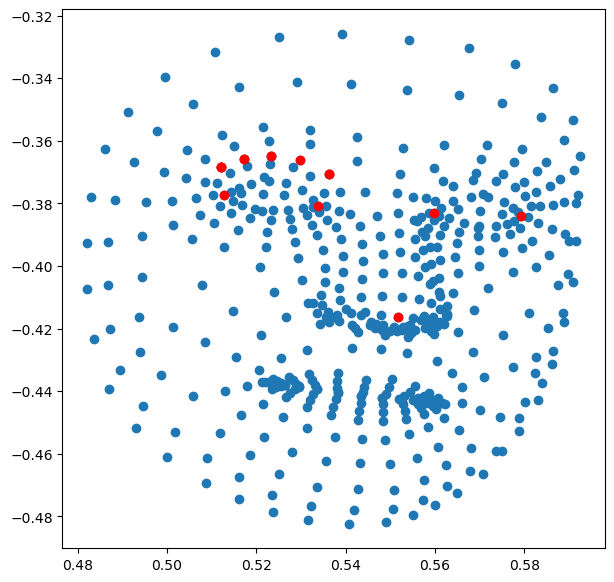

In [213]:
# lets also plot a frame of the facemesh and mark the points that we now have selected
    # take a row of the data
frame = 1
MTface_frame = MTface.iloc[frame]
# remove all Z 0 to 477
xcols = [col for col in MTface_frame.index if 'X_' in col]
ycols = [col for col in MTface_frame.index if 'Y_' in col]

    # remove all rotations
MTface_frame = MTface_frame[MTface_frame.index.str.contains('rotation_')==False]
# plot the 2d face
plt.figure(figsize=(7,7))
plt.scatter(MTface_frame[xcols ], MTface_frame[ycols]*-1)

# mark all_selected_eye_landmarks
for landmark in all_selected_eye_landmarks:
    plt.scatter(MTface_frame[landmark[0]], MTface_frame[landmark[1]]*-1, c='r')
plt.show()

# Section 2: Kinematics of head movements
Below we plot the head movement from the example video above. We plot all rotations over time. We also apply some smoothing filtering to reduce noise-related jitter. We use a savitsky golai filter for this, with a span of x (determining how many adjecent points are taken into account to determint current point value, i.e., increased values increas smoothnes), and a order of y (which relates to how aggressive the filter is to exclude high frequency jitter, i.e., increased values increas smoothnes), such that savgol_filter(timeseries, x, y).


### Excercise
As an excercise, try to comment out the smoothing, or to adjust the values of the smoothing to assess differences in the timeseries curve.

### Further study to learn more about timeseries and smoothing
[Winter, A. (2009). Biomechanics and Motor Control of Human Movement (Chapter 2). Wiley & Sons.](https://edisciplinas.usp.br/pluginfile.php/4174628/mod_resource/content/2/David%20A.%20Winter-Biomechanics%20and%20Motor%20Control%20of%20Human%20Movement-Wiley%20(2009).pdf)


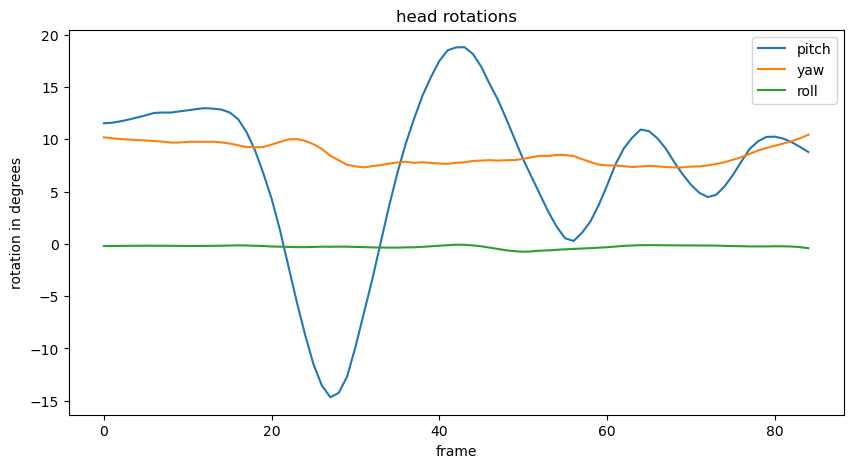

In [214]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

MTface = pd.read_csv(processed_data_fol + select_example + "_face.csv")
MTbody = pd.read_csv(processed_data_fol + select_example + "_body.csv")
# lets just show the head pitch
xrot = MTface['face_rotation_X']
yrot = MTface['face_rotation_Y']
zrot = MTface['face_rotation_Z']

  # smooth the pitch
xrot = savgol_filter(xrot, 11, 3) # you can change the span and order here, and you see that the smoothness of the curve will change accordingly
yrot = savgol_filter(yrot, 11, 3)
zrot = savgol_filter(zrot, 11, 3)

# now we can plot the nose vertical position
  # plot in one figure
plt.figure(figsize=(10,5))
plt.plot(xrot, label = 'pitch')
plt.plot(yrot, label = 'yaw')
plt.plot(zrot, label = 'roll')
plt.xlabel('frame')
plt.ylabel('rotation in degrees')
plt.title('head rotations')
plt.legend()
plt.show()

# Extracting gross features from the rotation data
So from the time series we can extract features that are indicative of the dynamics of the timevarying behavior. In head movements what could be of interest is how many turns or nods, and how deep the nods and turns are overall or maximally. So lets start with the number of peaks, and the prominences of the peaks ("how the peak stands out relative to the surrounding of the signal). We use a python package called scipy for this (https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.signal.peak_prominences.html)

### Excercise
As an excercise, try to think about another measure that we can extract from the rotation data. Think for example about rhythmicity, the tempo in which the peaks alternate, or symmetry of the nods?

peaks: [43 64]


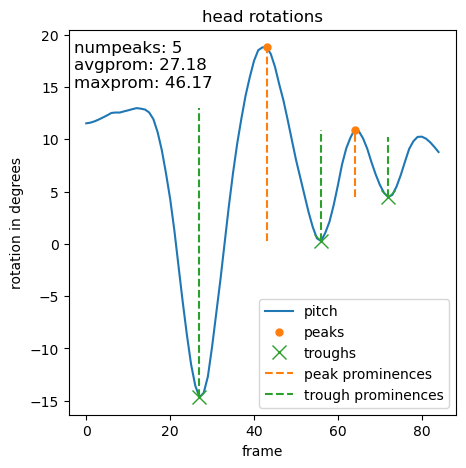

In [215]:
# store the peaks and and throughs of the head pitch, and plot it on the figure
from scipy.signal import find_peaks
from scipy.signal import find_peaks, peak_prominences

# set a peak function for head rotations, with 3 degress min threshold and 4 frames distance (100 ms, if 25frames per second)
def get_peak_head_data(rot, threshpeak=5, peakdist = 4, prominence=2):
    """This function takes a rotation time series and returns the peaks and troughs of the rotation time series."""
    peaks, _ = find_peaks(rot, height=threshpeak, distance=peakdist, prominence = prominence)  # Find peaks above the threshold
    troughs, _ = find_peaks(rot * -1, height=threshpeak*-1, distance=peakdist, prominence = prominence)  # Find troughs by inverting the series
    
    # Initialize default values
    peak_prom = trough_prom = np.array([])
    numpeaks = avgprom = maxprom = np.nan
    
    if len(peaks) > 0 and len(troughs) > 0:
        # Get the prominences of the peaks and troughs
        peak_prom = peak_prominences(rot, peaks)[0]
        trough_prom = peak_prominences(rot * -1, troughs)[0]
        
        # Calculate summary statistics
        numpeaks = len(peaks) + len(troughs)
        avgprom = np.mean(peak_prom) + np.mean(trough_prom)
        maxprom = np.max(peak_prom) + np.max(trough_prom)
    
    return peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom

#apply the function
peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom = get_peak_head_data(xrot)
print("peaks: " + str(peaks))
# do some plotting with the peaks overlay
plt.figure(figsize=(5,5))
plt.plot(xrot, label='pitch')
plt.plot(peaks, xrot[peaks], ".", label='peaks', markersize=10)
plt.plot(troughs, xrot[troughs], "x", label='troughs', markersize=10)
# Plot prominences for peaks
    # note that zip is used to iterate over two lists at the same time
for peak, prom in zip(peaks, peak_prom):
    plt.vlines(x=peak, ymin=xrot[peak] - prom, ymax=xrot[peak], color='C1', linestyle='--', label='peak prominences' if peak == peaks[0] else "")

# Plot prominences for troughs
for trough, prom in zip(troughs, trough_prom):
    plt.vlines(x=trough, ymin=xrot[trough], ymax=xrot[trough] + prom, color='C2', linestyle='--', label='trough prominences' if trough == troughs[0] else "")
# also plot the number of peaks and the average and max prominence in an upper left panel
plt.text(-3, 15, 'numpeaks: ' + str(round(numpeaks, 2)) + '\navgprom: ' + str(round(avgprom, 2)) + '\nmaxprom: ' + str(round(maxprom, 2)), fontsize=12)
plt.xlabel('frame')
plt.ylabel('rotation in degrees')
plt.title('head rotations')
plt.legend()
plt.show()

# Hand movement kinematics
We can do a similar thing for the hand movement. We will work with the body timeseries which has the index finger too. Lets first plot the raw data of the movement. To get a sense of what this looks like for example 2, where there is some hand movement. Note that usually movement researchers will use x,y,z to indicate horizontal, depth, and vertical dimensions. Mediapipe deviates from this and puts y as vertical dimension. Bit confusing, but well work with it for now (also to learn that you always need to be careful with interpreting).

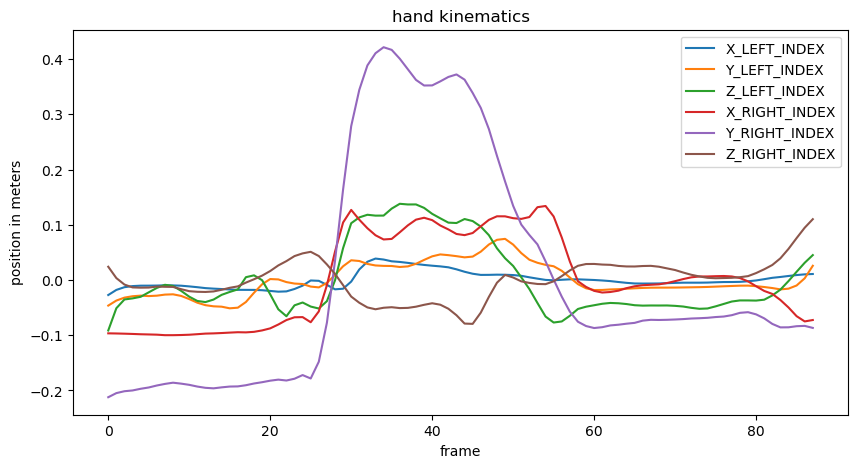

In [216]:
# Lets also extract the kinematics of the hands
MTbody = pd.read_csv(processed_data_fol + select_example2 + "_body.csv")

# lets smooth the data for the index fingers in one line
coln = ['X_LEFT_INDEX', 'Y_LEFT_INDEX', 'Z_LEFT_INDEX', 'X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX']
MTbody[coln] = MTbody[coln].apply(lambda x: savgol_filter(x, 7, 3))

# lets center the index finger by the overall mean
MTbody['X_LEFT_INDEX'] = MTbody['X_LEFT_INDEX'] - MTbody['X_LEFT_INDEX'].mean()
MTbody['Y_LEFT_INDEX'] = (MTbody['Y_LEFT_INDEX'] - MTbody['Y_LEFT_INDEX'].mean())*-1 # note here that i flip the axis so that up is positive
MTbody['Z_LEFT_INDEX'] = MTbody['Z_LEFT_INDEX'] - MTbody['Z_LEFT_INDEX'].mean()
MTbody['X_RIGHT_INDEX'] = MTbody['X_RIGHT_INDEX'] - MTbody['X_RIGHT_INDEX'].mean()
MTbody['Y_RIGHT_INDEX'] = (MTbody['Y_RIGHT_INDEX'] - MTbody['Y_RIGHT_INDEX'].mean())*-1 # note here that i flip the axis so that up is positive
MTbody['Z_RIGHT_INDEX'] = MTbody['Z_RIGHT_INDEX'] - MTbody['Z_RIGHT_INDEX'].mean()

# lets plot the hand kinematics
plt.figure(figsize=(10,5))
plt.plot(MTbody['X_LEFT_INDEX'], label = 'X_LEFT_INDEX')
plt.plot(MTbody['Y_LEFT_INDEX'], label = 'Y_LEFT_INDEX')
plt.plot(MTbody['Z_LEFT_INDEX'], label = 'Z_LEFT_INDEX')
plt.plot(MTbody['X_RIGHT_INDEX'], label = 'X_RIGHT_INDEX')
plt.plot(MTbody['Y_RIGHT_INDEX'], label = 'Y_RIGHT_INDEX')
plt.plot(MTbody['Z_RIGHT_INDEX'], label = 'Z_RIGHT_INDEX')
plt.xlabel('frame')
plt.ylabel('position in meters')
plt.title('hand kinematics')
plt.legend()
plt.show()

# Extracting features from the hand movements
We will start with the speed. Below is a calculation of this. We calculate the 2D speed, because the depth dimension is less reliable in mediapipe.

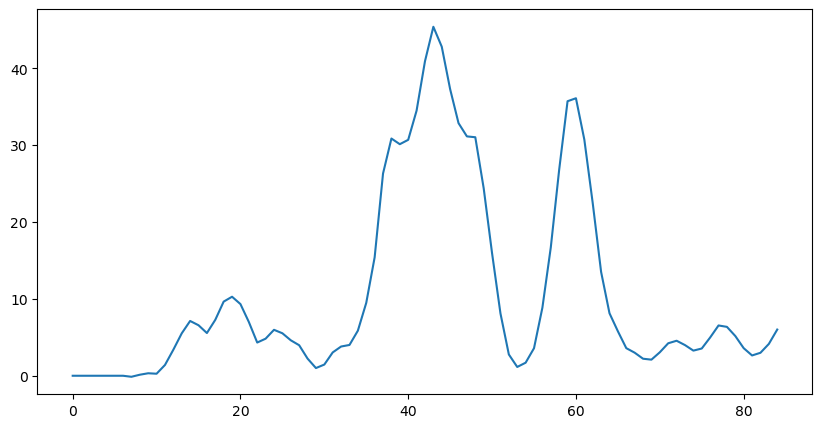

In [220]:
MTbody = pd.read_csv(processed_data_fol + select_example + "_body.csv")
# lets compute the speed based on 2D data
def calcspeed(MTbody, coln, assumed_framerate = 30):
    """This function calculates the speed of the hands in cm/s"""
    # lets smooth the data for the index fingers in one line
        # smooth using lambda
    MTbody[coln] = MTbody[coln].apply(lambda x: savgol_filter(x, 7, 3)) 
    handspeed = np.sqrt((MTbody[coln[0]].diff()**2) + (MTbody[coln[1]].diff()**2)) # were note using z dimension
    handspeed = handspeed*assumed_framerate # per second
    handspeed = handspeed*100 # to cm
    # set speed to zero if not visible using visibility
    visible= MTbody['visibility_' + coln[0].split('_')[1]+'_'+coln[0].split('_')[2]] < .85
    handspeed[visible] = 0
    #set NaN to 0
    handspeed = handspeed.fillna(0)
    # smooth the speed
    handspeed = savgol_filter(handspeed, 7, 3)
    return handspeed

# get the speed
MTbody['speed_left_index'] = calcspeed(MTbody, coln = ['X_LEFT_INDEX', 'Y_LEFT_INDEX'])
MTbody['speed_right_index'] = calcspeed(MTbody, coln = ['X_RIGHT_INDEX', 'Y_RIGHT_INDEX'])

# plot handspeed
plt.figure(figsize=(10,5))
plt.plot(MTbody['speed_left_index'], label = 'speed_right_index')
plt.show()


### Extractig peaks from the speed
We can extract some features based on the peaks of the speed of the hands. We extract, number of peaks, average height of the peak (average velocity peaks) and maximum of the peak.

#### Excercise
As an excercise, try to think about another measure that we can extract. Maybe we want to be more specific, and extract peaks from the vertical or horizontal velocity instead (which contains information about movement direction).

peaks: [43 60]


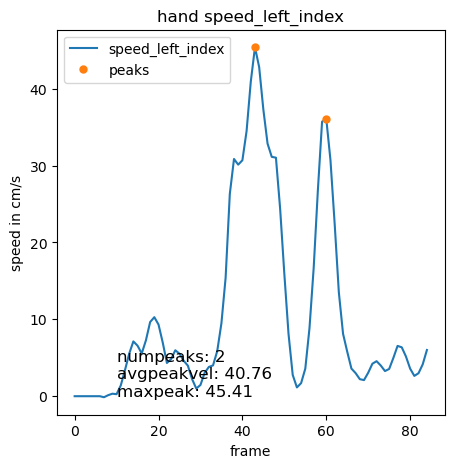

In [224]:
# Set up a function that extracts the peaks and troughs of the hand speed
def get_peak_hand_data(ts, dist = 8, thresh = 15, prominence = 5):
    """This function takes the some hand time series and returns the peaks and troughs of the rotation time series"""
    peaks, _ = find_peaks(ts, height=thresh, distance=dist, prominence = 5)  # lets set the height to 15 cm/s, set space inbetween min 8 frames, and 5 minimal for
    # also collect the summary
        # number of peaks, throughs and peaks
    numpeaks = len(peaks)
        # average peak veleocity for movements
    average_peak_vel = np.mean(ts[peaks])
        # max magnitude peaks
    maxpeak = np.max(ts[peaks])
        # calculate the average distance between the peaks in frames
    return peaks, numpeaks, average_peak_vel, maxpeak

peaks, numpeaks, average_peak_vel, maxpeak = get_peak_hand_data(MTbody['speed_left_index'])
print("peaks: " + str(peaks))
plt.figure(figsize=(5,5))
plt.plot(MTbody['speed_left_index'], label='speed_left_index')
plt.plot(peaks, MTbody['speed_left_index'][peaks], ".", label='peaks', markersize=10)
# add some text
plt.text(10, 0, 'numpeaks: ' + str(round(numpeaks, 2)) + '\navgpeakvel: ' + str(round(average_peak_vel, 2)) + '\nmaxpeak: ' + str(round(maxpeak, 2)), fontsize=12)
plt.xlabel('frame')
plt.ylabel('speed in cm/s')
plt.title('hand speed_left_index')
plt.legend()
plt.show()

We can further look at the gesture space as a form of prominence. What is the space that is used to gesture?

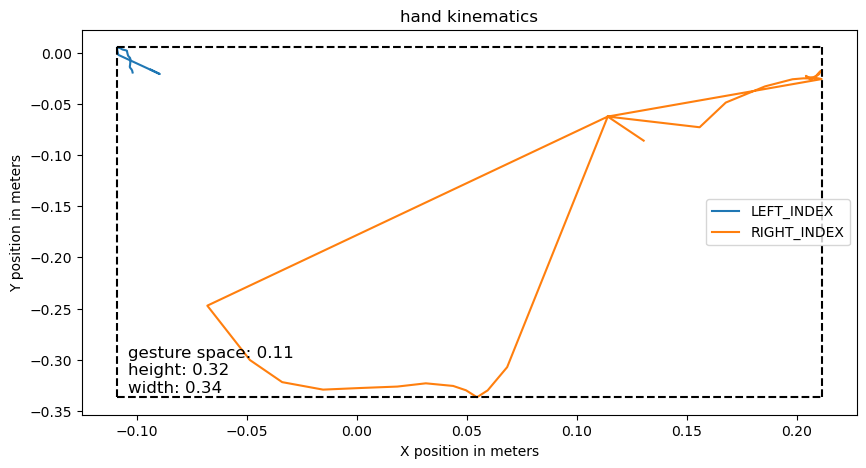

In [228]:
# we also add some information about the max hand height and max horizontal space (gesture space)
def gesturespace(MT):
    """This function calculates the maximum height and width of the hand gestures"""
    # set the position to the overall mean if visibility is below 0.85
    MT['X_LEFT_INDEX'][MT['visibility_LEFT_INDEX'] < 0.85] = MT['X_LEFT_INDEX'].mean()
    MT['Y_LEFT_INDEX'][MT['visibility_LEFT_INDEX'] < 0.85] = MT['Y_LEFT_INDEX'].mean()
    MT['X_RIGHT_INDEX'][MT['visibility_RIGHT_INDEX'] < 0.85] = MT['X_RIGHT_INDEX'].mean()
    MT['Y_RIGHT_INDEX'][MT['visibility_RIGHT_INDEX'] < 0.85] = MT['Y_RIGHT_INDEX'].mean()
    # get the max and min of the left and right hand
    minhorizontalleft = np.min(MT['X_LEFT_INDEX'])
    maxhorizontalleft = np.max(MT['X_LEFT_INDEX'])
    minverticalleft = np.min(MT['Y_LEFT_INDEX'])
    maxverticalleft = np.max(MT['Y_LEFT_INDEX'])
    minhorizontalright = np.min(MT['X_RIGHT_INDEX'])
    maxhorizontalright = np.max(MT['X_RIGHT_INDEX'])
    minverticalright = np.min(MT['Y_RIGHT_INDEX'])
    maxverticalright = np.max(MT['Y_RIGHT_INDEX'])
    # just take the min and max for both left and right
    minhorizontal = np.min([minhorizontalleft, minhorizontalright])
    maxhorizontal = np.max([maxhorizontalleft, maxhorizontalright])
    minvertical = np.min([minverticalleft, minverticalright])
    maxvertical = np.max([maxverticalleft, maxverticalright])
    # calculate the space as the area of the rectangle
    heightgesture = (maxhorizontal-minhorizontal)
    widthgesture = (maxvertical-minvertical)
    gspace = heightgesture*widthgesture
    return gspace, heightgesture, widthgesture, minhorizontal, maxhorizontal, minvertical, maxvertical


# plot the x, y of both left and right index and show the gesture space reactangle
gspace, heightgesture, widthgesture, minhorizontal, maxhorizontal, minvertical, maxvertical = gesturespace(MTbody)
plt.figure(figsize=(10,5))
plt.plot(MTbody['X_LEFT_INDEX'], MTbody['Y_LEFT_INDEX'], label = 'LEFT_INDEX')
plt.plot(MTbody['X_RIGHT_INDEX'], MTbody['Y_RIGHT_INDEX'], label = 'RIGHT_INDEX')
plt.plot([minhorizontal, minhorizontal], [minvertical, maxvertical], color='black', linestyle='--')
plt.plot([maxhorizontal, maxhorizontal], [minvertical, maxvertical], color='black', linestyle='--')
plt.plot([minhorizontal, maxhorizontal], [minvertical, minvertical], color='black', linestyle='--')
plt.plot([minhorizontal, maxhorizontal], [maxvertical, maxvertical], color='black', linestyle='--')
# add a label for the gesture space
plt.text(minhorizontal+0.005, minvertical+0.005, 'gesture space: ' + str(round(gspace, 2)) + '\nheight: ' + str(round(heightgesture, 2)) + '\nwidth: ' + str(round(widthgesture, 2)), fontsize=12)
plt.xlabel('X position in meters')
plt.ylabel('Y position in meters')
plt.title('hand kinematics')
plt.legend()
plt.show()
plt.close()

# making video
- Head pitch, yaw and roll peaks
- Hand speed peaks
- Hand gesture space

It is very tempting to now go ahead and extract all these features for each trial and do you statistical analysis. But a good inbetween step is sanity checking: do my time series data and my extracted measures match up with the actual audiovisual data? Do they make sense and do they indeed capture something of the dynamics your interested in? Or should I use other parameters for smoothing or select different keypoints, if not devise completely different measures based on what we see.


## Excercise
- Can you think of another plot that you could add instead of the envisionBOX logo?
- Can you improve the settings so that you dont get spurious peaks?


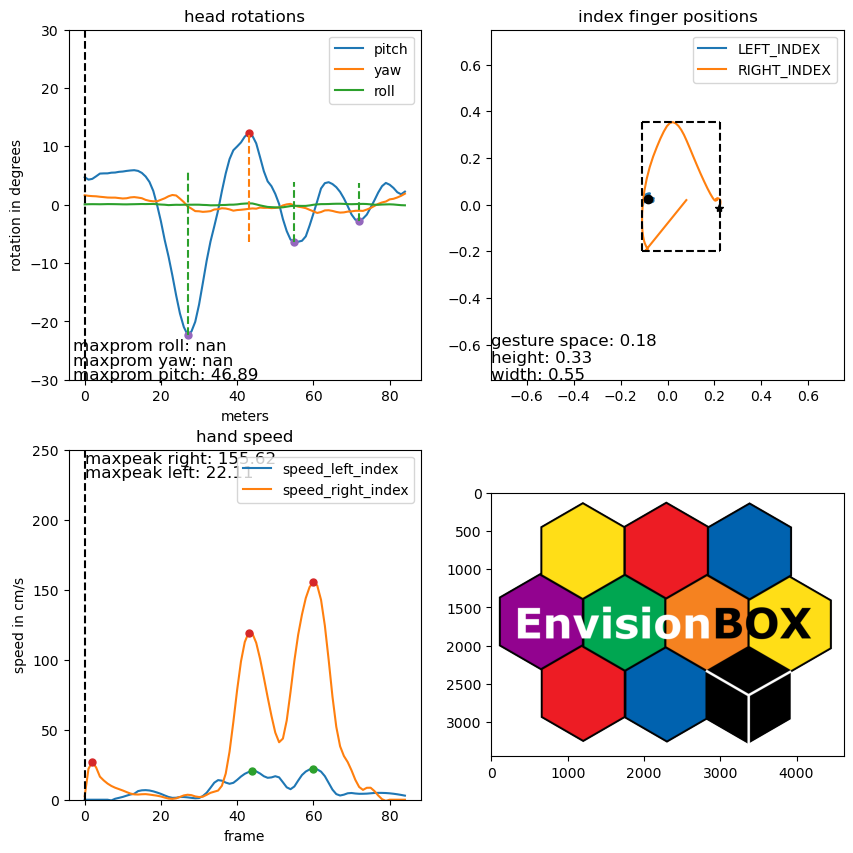

In [229]:
# lets make a plotting function that combines the above plots
def plot_multiple_speedpeaks_gesturespace(MTface, MTbody, current_frame_counter=0):
    # supress plotting
    plt.ioff()
    # make 4 plots (left upper: head rotations plus peaks, right upper: gesture space, left lower: hand speed, right lower: hand speed)
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    # plot the head rotations
    xrot = MTface['face_rotation_X']
    yrot = MTface['face_rotation_Y']
    zrot = MTface['face_rotation_Z']
    axs[0, 0].plot(xrot, label = 'pitch')
    axs[0, 0].plot(yrot, label = 'yaw')
    axs[0, 0].plot(zrot, label = 'roll')
    axs[0, 0].set_xlabel('frame')
    axs[0, 0].set_ylabel('rotation in degrees')
    axs[0, 0].set_title('head rotations')
      # set x and y max to highest range
    axs[0, 0].set_ylim(-30, 30) # set to 30 degree
    # add labels 
    axs[0, 0].legend()
    # get the peaks for pitch
    peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom = get_peak_head_data(xrot)
    if not np.isnan(numpeaks):
        axs[0, 0].plot(peaks, xrot[peaks], ".", label='peaks', markersize=10)
        axs[0, 0].plot(troughs, xrot[troughs], ".", label='peaks', markersize=10)
        for peak, prom in zip(peaks, peak_prom):
            axs[0, 0].vlines(x=peak, ymin=xrot[peak] - prom, ymax=xrot[peak], color='C1', linestyle='--', label='peak prominences' if peak == peaks[0] else "")
        for trough, prom in zip(troughs, trough_prom):
            axs[0, 0].vlines(x=trough, ymin=xrot[trough], ymax=xrot[trough] + prom, color='C2', linestyle='--', label='trough prominences' if trough == troughs[0] else "")
    axs[0, 0].text(-3, -30, 'maxprom pitch: ' + str(round(maxprom, 2)), fontsize=12)
    # get the peaks for yaw
    peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom = get_peak_head_data(yrot)
    if not np.isnan(numpeaks):
        axs[0, 0].plot(peaks, yrot[peaks], ".", label='peaks', markersize=10)
        axs[0, 0].plot(troughs, xrot[troughs], ".", label='peaks', markersize=10)
        for peak, prom in zip(peaks, peak_prom):
            axs[0, 0].vlines(x=peak, ymin=yrot[peak] - prom, ymax=yrot[peak], color='C1', linestyle='--', label='peak prominences' if peak == peaks[0] else "")
        for trough, prom in zip(troughs, trough_prom):
            axs[0, 0].vlines(x=trough, ymin=yrot[trough], ymax=yrot[trough] + prom, color='C2', linestyle='--', label='trough prominences' if trough == troughs[0] else "")
    axs[0, 0].text(-3, -27.5, 'maxprom yaw: ' + str(round(maxprom, 2)), fontsize=12)
    # get the peaks for roll
    peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom = get_peak_head_data(zrot)
    if not np.isnan(numpeaks):
        axs[0, 0].plot(peaks, zrot[peaks], ".", label='peaks', markersize=10)
        axs[0, 0].plot(troughs, xrot[troughs], ".", label='peaks', markersize=10)
        for peak, prom in zip(peaks, peak_prom):
            axs[0, 0].vlines(x=peak, ymin=zrot[peak] - prom, ymax=zrot[peak], color='C1', linestyle='--', label='peak prominences' if peak == peaks[0] else "")
        for trough, prom in zip(troughs, trough_prom):
            axs[0, 0].vlines(x=trough, ymin=zrot[trough], ymax=zrot[trough] + prom, color='C2', linestyle='--', label='trough prominences' if trough == troughs[0] else "")
    # add text with only the max prominences for each rotation x, y, z
    axs[0, 0].text(-3, -25, 'maxprom roll: ' + str(round(maxprom, 2)), fontsize=12)
    # plot the gesture space
    gspace, heightgesture, widthgesture, minhorizontal, maxhorizontal, minvertical, maxvertical = gesturespace(MTbody)
    axs[0, 1].plot(MTbody['X_LEFT_INDEX'], MTbody['Y_LEFT_INDEX'], label = 'LEFT_INDEX')
    axs[0, 1].plot(MTbody['X_RIGHT_INDEX'], MTbody['Y_RIGHT_INDEX'], label = 'RIGHT_INDEX')
    axs[0, 1].plot([minhorizontal, minhorizontal], [minvertical, maxvertical], color='black', linestyle='--')
    axs[0, 1].plot([maxhorizontal, maxhorizontal], [minvertical, maxvertical], color='black', linestyle='--')
    axs[0, 1].plot([minhorizontal, maxhorizontal], [minvertical, minvertical], color='black', linestyle='--')
    axs[0, 1].plot([minhorizontal, maxhorizontal], [maxvertical, maxvertical], color='black', linestyle='--')
    axs[0, 0].set_xlabel('meters')
    axs[0, 0].set_xlabel('meters')
    axs[0, 1].set_title('index finger positions')
    axs[0, 1].legend()
    # set x and y max to highest range
    axs[0, 1].set_xlim(-0.75, 0.75) # set to 1.5 meter
    axs[0, 1].set_ylim(-0.75, 0.75) # set to 1.5 meter
    # add a label for the gesture space
    axs[0, 1].text(-0.75, -0.75, 'gesture space: ' + str(round(gspace, 2)) + '\nheight: ' + str(round(heightgesture, 2)) + '\nwidth: ' + str(round(widthgesture, 2)), fontsize=12)
    # plot the hand speed
    axs[1, 0].plot(MTbody['speed_left_index'], label='speed_left_index')
    axs[1, 0].plot(MTbody['speed_right_index'], label='speed_right_index')
    axs[1, 0].set_xlabel('frame')
    axs[1, 0].set_ylabel('speed in cm/s')
    axs[1, 0].set_title('hand speed')
        # set max 250 cm/s
    axs[1, 0].set_ylim(0, 250)
    axs[1, 0].legend()
    # get the peaks for left hand speed
    peaks, numpeaks, average_peak_vel, maxpeak = get_peak_hand_data(MTbody['speed_left_index'])
    if not np.isnan(numpeaks):
        axs[1, 0].plot(peaks, MTbody['speed_left_index'][peaks], ".", label='peaks', markersize=10)
        # add some text for maxspeed only
        axs[1, 0].text(0, 230, 'maxpeak left: ' + str(round(maxpeak, 2)), fontsize=12)
    # get the peaks for right hand speed
    peaks, numpeaks, average_peak_vel, maxpeak = get_peak_hand_data(MTbody['speed_right_index'])
    if not np.isnan(numpeaks):
        axs[1, 0].plot(peaks, MTbody['speed_right_index'][peaks], ".", label='peaks', markersize=10)
        # add some text for maxspeed only
        axs[1, 0].text(0, 240, 'maxpeak right: ' + str(round(maxpeak, 2)), fontsize=12)
    ### frame counte inications
    # for the right lower plot lets now put a placeholde image of envisionbox
    axs[1, 1].imshow(plt.imread('./images/envision_banner.png'))
    # add a vertical line to the speed and rotation plots at framecounter
    axs[0, 0].axvline(x=current_frame_counter, color='black', linestyle='--')
    axs[1, 0].axvline(x=current_frame_counter, color='black', linestyle='--')
    # now add an arrow to the current x,y position at frame counter
    currentlocleftindex = [MTbody['X_LEFT_INDEX'][current_frame_counter], MTbody['Y_LEFT_INDEX'][current_frame_counter]]
    currentlocrightindex = [MTbody['X_RIGHT_INDEX'][current_frame_counter], MTbody['Y_RIGHT_INDEX'][current_frame_counter]] 
    axs[0, 1].plot(currentlocleftindex[0], currentlocleftindex[1], 'o', color='black')
    axs[0, 1].plot(currentlocrightindex[0], currentlocrightindex[1], '*', color='black')
    plt.close()
    return fig
    
#### lets do some testing of this function
# lets load in in the MTbody and MTface again
MTface = pd.read_csv(processed_data_fol + select_example + "_face.csv")
MTbody = pd.read_csv(processed_data_fol + select_example + "_body.csv")

# smooth the data for the face (rotations) and body (index)
colnamesf = ['face_rotation_X', 'face_rotation_Y', 'face_rotation_Z']
MTface[colnamesf] = MTface[colnamesf].apply(lambda x: savgol_filter(x, 7, 3))
    # center the face data using lambda
MTface[colnamesf] = MTface[colnamesf].apply(lambda x: x - x.mean())
colnamesb = ['X_LEFT_INDEX', 'Y_LEFT_INDEX', 'Z_LEFT_INDEX', 'X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX']
    # flip the y axis
MTbody['Y_LEFT_INDEX'] = MTbody['Y_LEFT_INDEX']*-1
MTbody['Y_RIGHT_INDEX'] = MTbody['Y_RIGHT_INDEX']*-1
    # smooth the body data
MTbody[colnamesb] = MTbody[colnamesb].apply(lambda x: savgol_filter(x, 17, 3))
    # add speed
MTbody['speed_left_index'] = calcspeed(MTbody, coln = ['X_LEFT_INDEX', 'Y_LEFT_INDEX', 'Z_LEFT_INDEX'])
MTbody['speed_right_index'] = calcspeed(MTbody, coln = ['X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX'])

# test function
    # print current working drive
plotbig = plot_multiple_speedpeaks_gesturespace(MTface, MTbody)
plotbig


# Lets create videos for sanitychecking
The following code takes quite some time, as you need to render a plot every frame (!). We first set the pre-prepocessing that we might want to change.

In [230]:
# preprocessing settings
def preprocessing(MTface, MTbody):
    """This function preprocesses the data for the face and body"""
    # smooth the face data
    colnamesf = ['face_rotation_X', 'face_rotation_Y', 'face_rotation_Z']
    MTface[colnamesf] = MTface[colnamesf].apply(lambda x: savgol_filter(x, 7, 3))
    MTface[colnamesf] = MTface[colnamesf].apply(lambda x: x - x.mean())
    # smooth the body data
    colnamesb = ['X_LEFT_INDEX', 'Y_LEFT_INDEX', 'Z_LEFT_INDEX', 'X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX']
    MTbody[colnamesb] = MTbody[colnamesb].apply(lambda x: savgol_filter(x, 7, 3))
    # flip the y axis
    MTbody['Y_LEFT_INDEX'] = MTbody['Y_LEFT_INDEX']*-1
    MTbody['Y_RIGHT_INDEX'] = MTbody['Y_RIGHT_INDEX']*-1
    # calculate the speed
    MTbody['speed_left_index'] = calcspeed(MTbody, coln = ['X_LEFT_INDEX', 'Y_LEFT_INDEX'])
    MTbody['speed_right_index'] = calcspeed(MTbody, coln = ['X_RIGHT_INDEX', 'Y_RIGHT_INDEX'])
    return MTface, MTbody

In [ ]:
# lets make a video where this plot is embedded on the left upper corner as a small plot with the vertical line moving
# we loop through each frame of the video using opencv, and add the plot to the video
# we also make a function as we are going to add this plot in a video to assess the velocity of the nose next to the video

# lets just load some packages again that we need here
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import Video
import matplotlib.pyplot as plt 
import tempfile
from moviepy.editor import VideoFileClip

tempfolder = tempfile.mkdtemp()

# loop through all the videos
for video in all_videos:
    print('working on' + video)
    # Load in the video
    cap = cv2.VideoCapture(video)
    frametotal = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #supposed framecount
    # get the frame width and height and make it bigger
    frame_width = int(cap.get(3))*3
    frame_height = int(cap.get(4))*3
    # define the codec and create a VideoWriter object
    # replace backward slash with forward
    newvideoname = video.replace('\\', '/')
    newvideoname = newvideoname.split('/')[-1]
    print('processing video: ' + newvideoname)
    out = cv2.VideoWriter('../augmented_videos/'+newvideoname, cv2.VideoWriter_fourcc('M','J','P','G'), 25, (frame_width*2,frame_height))
    MTbody = pd.read_csv(processed_data_fol + newvideoname.split('.')[0] + "_body.csv")
    MTface = pd.read_csv(processed_data_fol + newvideoname.split('.')[0] + "_face.csv")
    # preprocess the data
    MTface, MTbody = preprocessing(MTface, MTbody)
    # loop through the video and add the plot to the video on left upper corner in small inset
    frame_number = 0
    # while opened
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frame = cv2.resize(frame, (int(frame_width), int(frame_height)))
            # generate tempfolder
            plotbig = plot_multiple_speedpeaks_gesturespace(MTface, MTbody, current_frame_counter=frame_number)
            plotbig.savefig(tempfolder + '/tempfig.png')
            # load in plot as image
            plotimg = cv2.imread(tempfolder + '/tempfig.png')
            # delete the image
            os.remove(tempfolder + '/tempfig.png')
            # resize the plot image
            plotimg = cv2.resize(plotimg, (int(frame_width), int(frame_height)))
            # concatenate this frame next to the video frame on the right                                 
            frame = np.concatenate((frame, plotimg), axis=1)            
            out.write(frame)
            frame_number += 1
        else:
            break
    cap.release()
    out.release()
    # Release everything if job is finished so that you can open it in your regular video player
    clip = VideoFileClip('../augmented_videos/'+ newvideoname)
    clip.write_videofile('../augmented_videos/rerendered/'+ newvideoname)

In [232]:
    # show the first video
Video(allrerenderdvideos[0], embed=True, width=900)

## Lets now get the numerical data with the settings you like
Now that we have done some sanity checking. We can move on and extract all the numerical data. You can actually just adde to you meta data new columns with summary features for each trial. See below how our metadata file looks like. We have a trial ID, some condition variable (just a dummy here), and maybe some other variables. We can just add columns to it and save for each trial some new information.

### Excercise
You have added some new things hopefully during the excercises. Could you make sure that they are corerctly saved into you dataframe?

In [169]:
# the flat dataset is a dataset where for each trial you have aggregated information (already)
print(meta.head())

  trial_name condition  type
0   01_b_P16    dummy1  test
1    02_a_P8    dummy1  test
2    09_a_P7    dummy2  test
3   17_a_P15    dummy2  test
4   21_b_P12    dummy1  test


In [234]:
# now lets loop through the meta data, enrich the columns with kinematic summary data 
# lets loop through the meta
for row in range(len(meta)):
    # get the trial name
    trial_name = meta['trial_name'][row]
    # Load in the facial landmarks data
    MTface = pd.read_csv(processed_data_fol + trial_name + "_face.csv")
    MTbody = pd.read_csv(processed_data_fol + trial_name + "_body.csv")
    # preprocess the data
    MTface, MTbody = preprocessing(MTface, MTbody)
    # get the head pitch peaks
    peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom = get_peak_head_data(MTface['face_rotation_X'])
    # save the data in the meta
    meta.at[row, 'head_pitch_peaks'] = numpeaks
    meta.at[row, 'head_pitch_avgprom'] = avgprom
    meta.at[row, 'head_pitch_maxprom'] = maxprom
    # get the head yaw peaks
    peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom = get_peak_head_data(MTface['face_rotation_Y'])
    # save the data in the meta
    meta.at[row, 'head_yaw_peaks'] = numpeaks
    meta.at[row, 'head_yaw_avgprom'] = avgprom
    meta.at[row, 'head_yaw_maxprom'] = maxprom
    # get the head roll peaks
    peaks, peak_prom, troughs, trough_prom, numpeaks, avgprom, maxprom = get_peak_head_data(MTface['face_rotation_Z'])
    # save the data in the meta
    meta.at[row, 'head_roll_peaks'] = numpeaks
    meta.at[row, 'head_roll_avgprom'] = avgprom
    meta.at[row, 'head_roll_maxprom'] = maxprom
    # get the hand speed peaks
    peaks, numpeaks, average_peak_vel, maxpeak = get_peak_hand_data(MTbody['speed_left_index'])
    # save the data in the meta
    meta.at[row, 'hand_speed_left_peaks'] = numpeaks
    meta.at[row, 'hand_speed_left_avgpeak'] = average_peak_vel
    meta.at[row, 'hand_speed_left_maxpeak'] = maxpeak
    # get the hand speed peaks
    peaks, numpeaks, average_peak_vel, maxpeak = get_peak_hand_data(MTbody['speed_right_index'])
    # save the data in the meta
    meta.at[row, 'hand_speed_right_peaks'] = numpeaks
    meta.at[row, 'hand_speed_right_avgpeak'] = average_peak_vel
    meta.at[row, 'hand_speed_right_maxpeak'] = maxpeak
    # get the gesture space
    gspace, heightgesture, widthgesture, minhorizontal, maxhorizontal, minvertical, maxvertical = gesturespace(MTbody)
    # save the data in the meta
    meta.at[row, 'gesture_space'] = gspace
    meta.at[row, 'gesture_height'] = heightgesture
    meta.at[row, 'gesture_width'] = widthgesture
 # save the meta as an enriched file
meta.to_csv("../meta/meta_dummy_enriched.csv", index=False)

print('this is what the enriched "flat" dataset now looks like after extracting the kinematics')
meta.head()

this is what the enriched "flat" dataset now looks like after extracting the kinematics


trial_name condition  type  head_pitch_peaks  head_pitch_avgprom  \
0   01_b_P16    dummy1  test               7.0           10.384594   
1    02_a_P8    dummy1  test               5.0           14.325548   
2    09_a_P7    dummy2  test               NaN                 NaN   
3   17_a_P15    dummy2  test               NaN                 NaN   
4   21_b_P12    dummy1  test               4.0           10.993131   

   head_pitch_maxprom  head_yaw_peaks  head_yaw_avgprom  head_yaw_maxprom  \
0           20.278464             3.0         23.631353         26.948523   
1           23.741412             NaN               NaN               NaN   
2                 NaN             NaN               NaN               NaN   
3                 NaN             NaN               NaN               NaN   
4           12.791054             NaN               NaN               NaN   

   head_roll_peaks  ...  head_roll_maxprom  hand_speed_left_peaks  \
0              NaN  ...                NaN                    3.0   
1              NaN  ...                NaN                    4.0   
2              NaN  ...                NaN                    0.0   
3              NaN  ...                NaN                    0.0   
4              NaN  ...                NaN                    3.0   

   hand_speed_left_avgpeak  hand_speed_left_maxpeak  hand_speed_right_peaks  \
0               156.389025               210.409314                     9.0   
1                94.224422               164.126991                     6.0   
2                      NaN                      NaN                     1.0   
3                      NaN                      NaN                     2.0   
4                70.236509               113.055866                     3.0   

   hand_speed_right_avgpeak  hand_speed_right_maxpeak  gesture_space  \
0                 81.488176                250.727142       0.262754   
1                100.278225                198.381721       0.138539   
2                 58.473166                 58.473166       0.012066   
3                123.057173                201.840128       0.089115   
4                138.095452                232.055339       0.185006   

   gesture_height  gesture_width  
0        0.437633       0.600398  
1        0.234211       0.591511  
2        0.034852       0.346218  
3        0.160349       0.555756  
4        0.342062       0.540855  

[5 rows x 21 columns]

### Plot the summarized data
In our metadata we now have condition as a variable. We also have the kinematic summary data for each trial. So we can start working with this in our plots and statistical analysis. Below is some code for two panel figure with the differences in condition and the nose max amplitude and the nose max velocity. 

#### Excercise
Could you plot some other things? Could you create another plot, seeing whether some features are correlated?

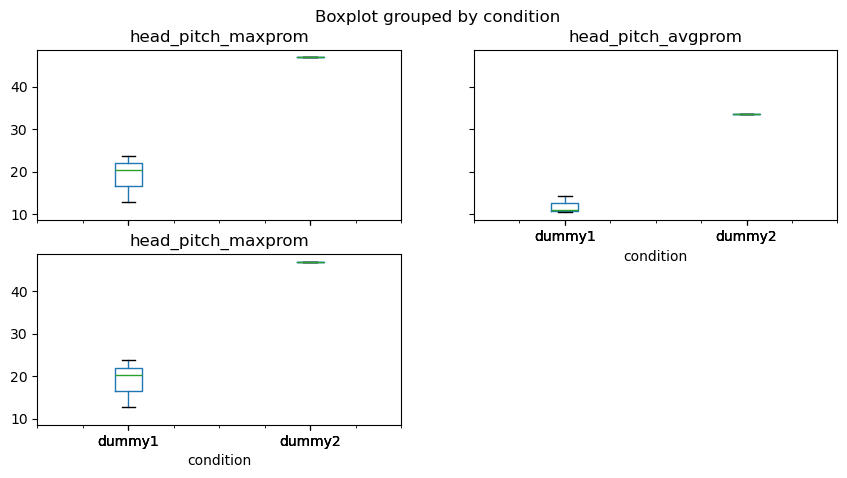

In [251]:
# lets make a boxplot with the new meta data
import matplotlib.pyplot as plt
import numpy as np

# Load in the enriched meta data
meta = pd.read_csv("../meta/meta_dummy_enriched.csv")

# lets make a boxplot with jitters with condition on the x axis
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# per condition plot the pitch max prominences pitch, peak velocity, max gesture space, ignoring NaNs, variable y axis
meta.boxplot(column=['head_pitch_maxprom', 'head_pitch_avgprom', 'head_pitch_maxprom' ], by='condition', ax=ax[0], grid=False)
# acis
ax[0].set_xlabel('condition')
ax[0].set_ylabel('degrees per second')

plt.show()
plt.close()


# Section x: Brow raises [Under Construction]
It turns out that the brow raises are not as reliable and they seem to be correlated with head pitch. This is also obtained in one of the following papers: https://arxiv.org/html/2403.10367v1. Thus we need to correct for the head pitch to get reliable brow raises. This was also shown in the following paper Anna Kuznetsova & Vadim Kimmelman: https://arxiv.org/html/2403.10367v1. I will leave this feature for future contributions to this module. 

In [ ]:
# for the brow movement we are also making a function
def get_brow_movement(MTface):
    # create a temporaroy MTface dataframe 
    MTface_proc = MTface.copy()
    # lets first smooth the eye points a little
    for marker in all_selected_eye_landmarks:
        for i in range(3):
            MTface_proc[marker[i]] = savgol_filter(MTface_proc[marker[i]], 26, 3)

    # left brow: lets determine the centroid of the left eye
    left_eye_mid_x = (MTface[left_inner_eye[0][0]] + MTface[left_inner_eye[1][0]])/2
    left_eye_mid_y = (MTface[left_inner_eye[0][1]] + MTface[left_inner_eye[1][1]])/2
    left_eye_mid_z = (MTface[left_inner_eye[0][2]] + MTface[left_inner_eye[1][2]])/2

        # determine the average euclidean distance between all brow points to this centroid
    distances_left = []
    for browpoint in left_brows:
        # normalize the eye-center-brow distance by the euclidean distance between the nose and the centroid of the left and righ eyes centers
         # normalize the distance by the euclidean distance between the nose and the centroid of the left and righ eyes centers
        norm_x1 = MTface[normalizationpoints[0][0]]
        norm_y1 = MTface[normalizationpoints[0][1]]
        norm_z1 = MTface[normalizationpoints[0][2]]
        norm_x2 = MTface[normalizationpoints[1][0]]
        norm_y2 = MTface[normalizationpoints[1][1]]
        norm_z2 = MTface[normalizationpoints[1][2]]
        normdist = np.sqrt((norm_x1 - norm_x2)**2 + (norm_y1 - norm_y2)**2 + (norm_z1 - norm_z2)**2)
        dist = np.sqrt((MTface[browpoint[0]] - left_eye_mid_x)**2 + (MTface[browpoint[1]] - left_eye_mid_y)**2 + (MTface[browpoint[2]] - left_eye_mid_z)**2)
        # distrance from nose to center of eyes
        distances_left.append(dist-normdist)
    mean_browdistances_left = np.mean(distances_left, axis=0)
    # lets smooth another time
    mean_browdistances_left = savgol_filter(mean_browdistances_left, 26, 3)
        # also center by itself
    mean_browdistances_left = mean_browdistances_left - np.mean(mean_browdistances_left)

        # do the same for the right brow
    right_eye_mid_x = (MTface[right_inner_eye[0][0]] + MTface[right_inner_eye[1][0]])/2
    right_eye_mid_y = (MTface[right_inner_eye[0][1]] + MTface[right_inner_eye[1][1]])/2
    right_eye_mid_z = (MTface[right_inner_eye[0][2]] + MTface[right_inner_eye[1][2]])/2

            # determine the average euclidean distance between all brow points to this centroid 
    distances_right = []
    for browpoint in right_brows:
        # normalize the distance by the euclidean distance between the nose and the centroid of the left and righ eyes centers
        norm_x1 = MTface[normalizationpoints[0][0]]
        norm_y1 = MTface[normalizationpoints[0][1]]
        norm_z1 = MTface[normalizationpoints[0][2]]
        norm_x2 = MTface[normalizationpoints[1][0]]
        norm_y2 = MTface[normalizationpoints[1][1]]
        norm_z2 = MTface[normalizationpoints[1][2]]
        normdist = np.sqrt((norm_x1 - norm_x2)**2 + (norm_y1 - norm_y2)**2 + (norm_z1 - norm_z2)**2)
        # distance from nose to center of eyes
        dist = np.sqrt((MTface[browpoint[0]] - right_eye_mid_x)**2 + (MTface[browpoint[1]] - right_eye_mid_y)**2 + (MTface[browpoint[2]] - right_eye_mid_z)**2)
        distances_right.append(dist-normdist)
    mean_browdistances_right = np.mean(distances_right, axis=0)
    # lets smooth another time
    mean_browdistances_right = savgol_filter(mean_browdistances_right, 26, 3)
    mean_browdistances_right = mean_browdistances_right - np.mean(mean_browdistances_right)
    return mean_browdistances_left, mean_browdistances_right
